## Introduction

## Theory

## Methods

In [2]:
import pandas as pd
ipums = pd.read_csv('../data/cleaned_data/ipums_cleaned.csv')
ipums = ipums.drop(columns=['Unnamed: 0'])
ipums.head()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


,year,sample,city_population_00s,age,income
0,2021,202101,2915,21,10500
1,2021,202101,2915,21,33000
2,2021,202101,2915,91,4300
3,2021,202101,2915,47,21000
4,2021,202101,2915,80,10200


In [29]:
import sklearn.cluster
import numpy as np
import matplotlib as plt
from matplotlib.pyplot import subplot
def plot(X,color_vector):
    fig, ax = plt.pyplot.subplots()
    ax.scatter(X[:,0], X[:,1],c=color_vector, cmap="viridis") #, alpha=0.5) #, c=y
    ax.set(xlabel='Feature-1 (x_1)', ylabel='Feature-2 (x_2)',
    title='Cluster data')
    ax.grid()
    # fig.savefig("test.png")
    plt.pyplot.show()


In [24]:
X = ipums.drop(columns=['year','sample'])

# THIS WILL ITERATE OVER ONE HYPER-PARAMETER (GRID SEARCH) 
# AND RETURN THE CLUSTER RESULT THAT OPTIMIZES THE SILHOUETTE SCORE
def maximize_silhouette(X,algo="birch",nmax=20,i_plot=False):

    # PARAM
    i_print=False

    #FORCE CONTIGUOUS
    X=np.ascontiguousarray(X) 

    # LOOP OVER HYPER-PARAM
    params=[]; sil_scores=[]
    sil_max=-10
    for param in range(2,nmax+1):
        if(algo=="birch"):
            model = sklearn.cluster.Birch(n_clusters=param).fit(X)
            labels=model.predict(X)

        if(algo=="ag"):
            model = sklearn.cluster.AgglomerativeClustering(n_clusters=param).fit(X)
            labels=model.labels_

        if(algo=="dbscan"):
            param=0.5*(param-1)
            model = sklearn.cluster.DBSCAN(eps=param).fit(X)
            labels=model.labels_

        if(algo=="kmeans"):
            model = sklearn.cluster.KMeans(n_clusters=param).fit(X)
            labels=model.predict(X)

        try:
            sil_scores.append(sklearn.metrics.silhouette_score(X,labels))
            params.append(param)
        except:
            continue 

        if(i_print): print(param,sil_scores[-1])
        
        if(sil_scores[-1]>sil_max):
             opt_param=param
             sil_max=sil_scores[-1]
             opt_labels=labels

    print("OPTIMAL PARAMETER =",opt_param)

    if(i_plot):
        fig, ax = plt.pyplot.subplots()
        ax.plot(params, sil_scores, "-o")  
        ax.set(xlabel='Hyper-parameter', ylabel='Silhouette')
        plt.pyplot.show()

    return opt_labels

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


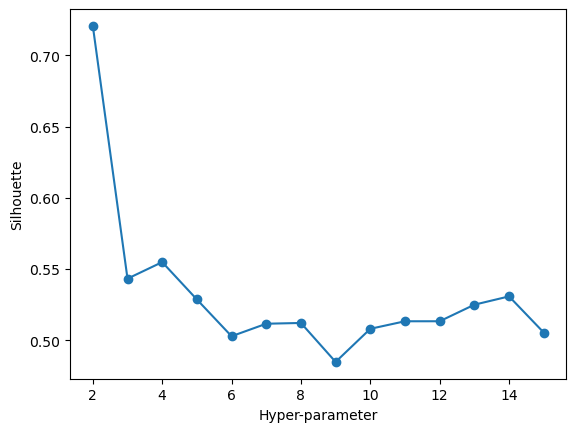

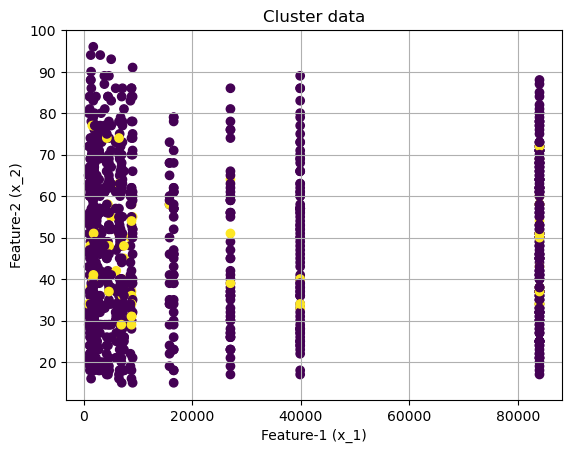

In [39]:
X_short = X.sample(n=1000)
# KMEANS
opt_labels=maximize_silhouette(X_short,algo="kmeans",nmax=15, i_plot=True)
plot(X_short.to_numpy(),opt_labels)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


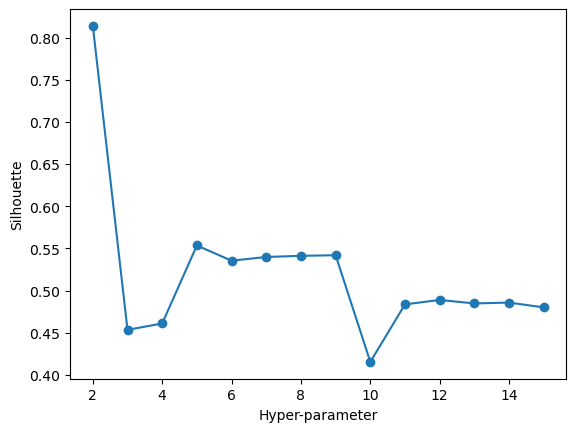

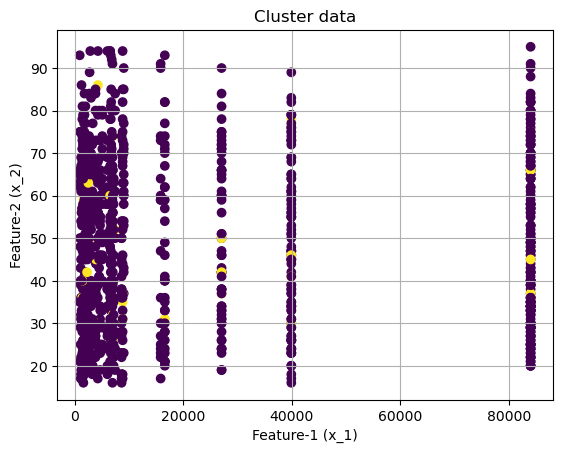

In [35]:
# AGGLOMERATIVE CLUSTERING
opt_labels=maximize_silhouette(X_short,algo="ag",nmax=15, i_plot=True)
plot(X_short.to_numpy(),opt_labels)

In [ ]:
# DBSCAN
opt_labels=maximize_silhouette(X_short,algo="dbscan",nmax=15, i_plot=True)
plot(X_short,opt_labels)

In [ ]:
# BIRCH
opt_labels=maximize_silhouette(X_short,algo="birch",nmax=15, i_plot=True)
plot(X_short,opt_labels)

## Results

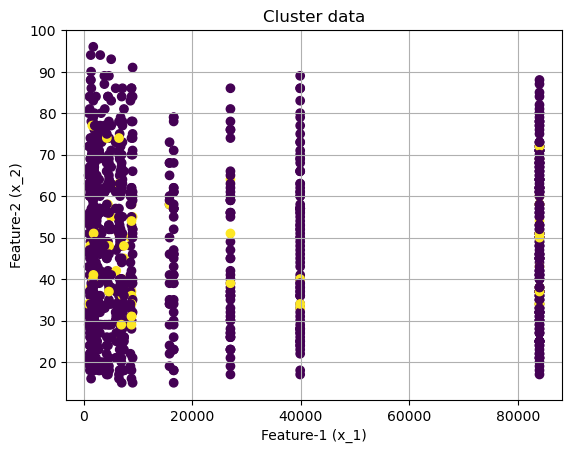

In [40]:
#KMEANS
model = sklearn.cluster.KMeans(n_clusters=2).fit(X_short.to_numpy())
labels=model.predict(X_short.to_numpy())
plot(X_short.to_numpy(),labels)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


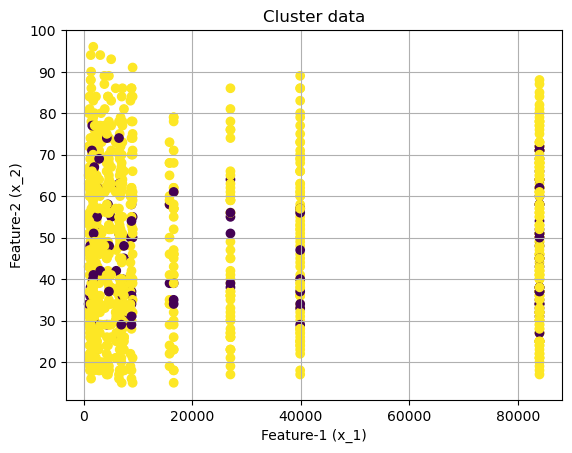

In [42]:
# Birch
model = sklearn.cluster.Birch(n_clusters=2).fit(X_short.to_numpy())
labels=model.predict(X_short.to_numpy())
plot(X_short.to_numpy(),labels)

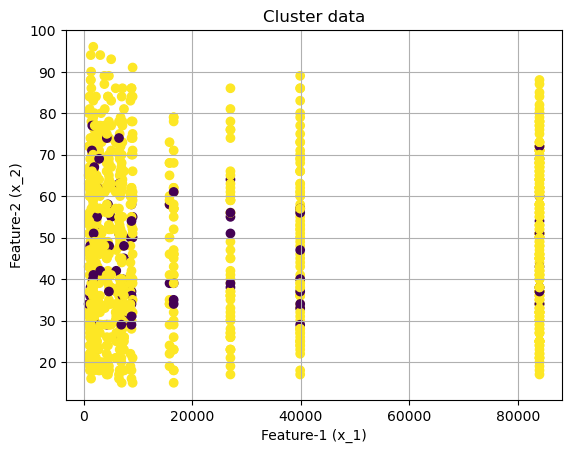

In [43]:
# Agglomerative
model = sklearn.cluster.AgglomerativeClustering(n_clusters=2).fit(X_short.to_numpy())
labels=model.labels_
plot(X_short.to_numpy(),labels)

## Conclusions